In [33]:
import pathlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
print(tf.__version__)

2.5.0


In [2]:
dataset_path = keras.utils.get_file("auto-mpg.data", "http://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")
dataset_path

'/Users/simo/.keras/datasets/auto-mpg.data'

In [3]:
column_names = ['MPG','Cylinders','Displacement','Horsepower','Weight',
                'Acceleration', 'Model Year', 'Origin']
raw_dataset = pd.read_csv(dataset_path, names=column_names,
                      na_values = "?", comment='\t',
                      sep=" ", skipinitialspace=True)

dataset = raw_dataset.copy()
# 显示后面5行数据
dataset.tail()

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1
397,31.0,4,119.0,82.0,2720.0,19.4,82,1


In [4]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

In [5]:
dataset = dataset.dropna()

In [6]:
origin = dataset.pop('Origin')
origin.tail()

393    1
394    2
395    1
396    1
397    1
Name: Origin, dtype: int64

In [7]:
# 得到one-hot code
dataset['USA'] = (origin == 1) *1.0
dataset['Europe'] = (origin == 2) *1.0
dataset['Japan'] = (origin == 3) *1.0
dataset.tail() 

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Europe,Japan
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,1.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0
397,31.0,4,119.0,82.0,2720.0,19.4,82,1.0,0.0,0.0


In [8]:
train_dataset = dataset.sample(frac=0.8,random_state=0)
test_dataset = dataset.drop(train_dataset.index)

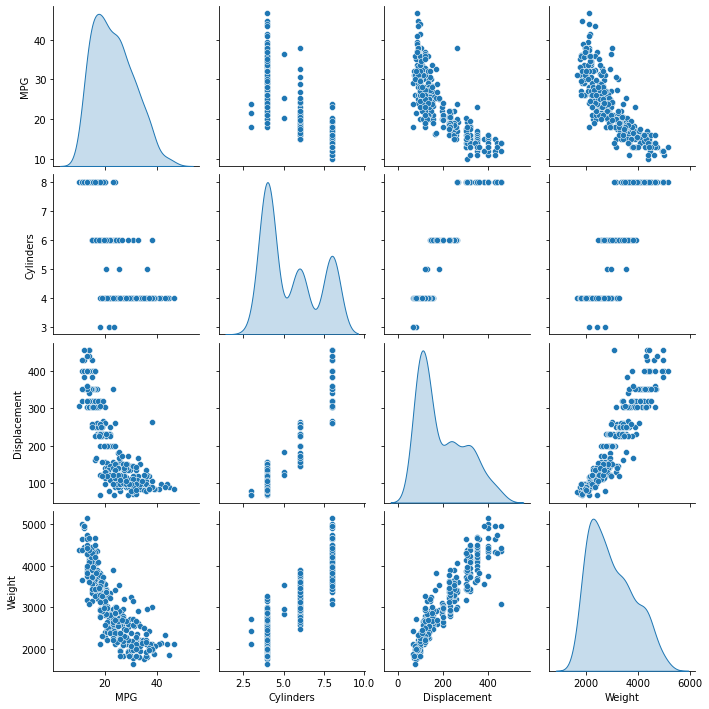

In [9]:
sns.pairplot(train_dataset[["MPG", "Cylinders", "Displacement", "Weight"]], diag_kind="kde")

In [10]:
train_stats = train_dataset.describe()
train_stats.pop("MPG")
train_stats = train_stats.transpose()
train_stats

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Europe,314.0,0.178344,0.383413,0.0,0.00,0.0,0.00,1.0
Japan,314.0,0.197452,0.398712,0.0,0.00,0.0,0.00,1.0


In [11]:
train_labels = train_dataset.pop('MPG')
test_labels = test_dataset.pop('MPG')

In [12]:
def norm(x):
  return (x - train_stats['mean']) / train_stats['std']
normed_train_data = norm(train_dataset)
normed_test_data = norm(test_dataset)

In [13]:
def build_model():
  model = keras.Sequential([
    layers.Dense(64, activation='relu', input_shape=[len(train_dataset.keys())]),
    layers.Dense(64, activation='relu'),
    layers.Dense(1)
  ])

  optimizer = tf.keras.optimizers.RMSprop(0.001)

  model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
  return model

In [14]:
model = build_model()
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                640       
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 65        
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


2021-07-25 11:41:50.306288: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
example_batch = normed_train_data[:10]
example_result = model.predict(example_batch)
example_result

2021-07-25 11:41:50.453106: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


array([[ 0.5492873 ],
       [ 0.38602954],
       [-0.18566337],
       [ 0.31478816],
       [ 0.28922963],
       [ 0.21302557],
       [ 0.34979475],
       [ 0.7289276 ],
       [ 0.14647949],
       [ 0.12165571]], dtype=float32)

In [24]:

EPOCHS = 20

history = model.fit(
  normed_train_data, train_labels,
  epochs=EPOCHS, validation_split = 0.2)

Epoch 1/20
8/8 [==============================] - 0s 14ms/step - loss: 41.9717 - mae: 5.0169 - mse: 41.9717 - val_loss: 32.0708 - val_mae: 4.7686 - val_mse: 32.0708
Epoch 2/20
8/8 [==============================] - 0s 6ms/step - loss: 29.7774 - mae: 4.2387 - mse: 29.7774 - val_loss: 24.5111 - val_mae: 4.0799 - val_mse: 24.5111
Epoch 3/20
8/8 [==============================] - 0s 11ms/step - loss: 22.8314 - mae: 3.6680 - mse: 22.8314 - val_loss: 20.4566 - val_mae: 3.6724 - val_mse: 20.4566
Epoch 4/20
8/8 [==============================] - 0s 8ms/step - loss: 18.4297 - mae: 3.2774 - mse: 18.4297 - val_loss: 17.6339 - val_mae: 3.3084 - val_mse: 17.6339
Epoch 5/20
8/8 [==============================] - 0s 7ms/step - loss: 15.7123 - mae: 3.0103 - mse: 15.7123 - val_loss: 15.4813 - val_mae: 3.1347 - val_mse: 15.4813
Epoch 6/20
8/8 [==============================] - 0s 10ms/step - loss: 14.1206 - mae: 2.8432 - mse: 14.1206 - val_loss: 13.7461 - val_mae: 2.9534 - val_mse: 13.7461
Epoch 7/20
8/

In [19]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch
hist.tail()

,loss,mae,mse,val_loss,val_mae,val_mse,epoch
5,254.620911,14.296348,254.620911,221.128784,13.163988,221.128784,5
6,193.745178,12.272831,193.745178,160.481186,11.097934,160.481186,6
7,139.399918,10.244596,139.399918,109.002777,9.062543,109.002777,7
8,94.525681,8.217156,94.525681,70.505981,7.147161,70.505981,8
9,62.447853,6.402446,62.447853,45.469364,5.677771,45.469364,9


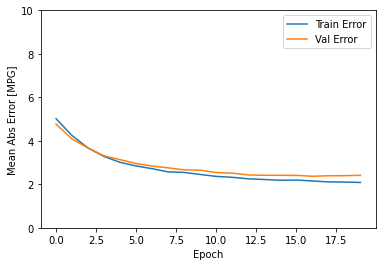

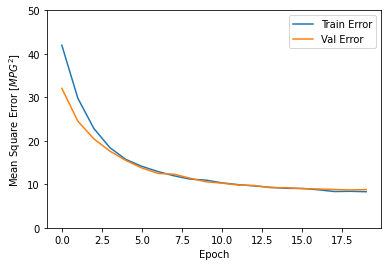

In [26]:
def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Abs Error [MPG]')
  plt.plot(hist['epoch'], hist['mae'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mae'],
           label = 'Val Error')
  plt.ylim([0,10])
  plt.legend()

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Mean Square Error [$MPG^2$]')
  plt.plot(hist['epoch'], hist['mse'],
           label='Train Error')
  plt.plot(hist['epoch'], hist['val_mse'],
           label = 'Val Error')
  plt.ylim([0,50])
  plt.legend()
  plt.show()


plot_history(history)

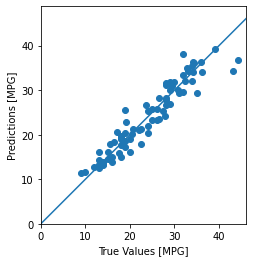

In [27]:
test_predictions = model.predict(normed_test_data).flatten()

plt.scatter(test_labels, test_predictions)
plt.xlabel('True Values [MPG]')
plt.ylabel('Predictions [MPG]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])


In [38]:
arr = np.array([[[1,2],[3,4]],
                [[5,6],[7,8]]
               ])
arr.shape

(2, 2, 2)